In [13]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os, re, random
import warnings, json
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from collections import Counter, defaultdict
from datetime import datetime
dates_dict = {
    'B_birthday': '%Y-%m-%d', 
    'B_dtopentime': '%Y-%m-%d %H:%M:%S'
}

current_folder = os.path.abspath(os.curdir)
root_folder = os.path.dirname(current_folder) 
data_folder = os.path.join(root_folder,'data')
%matplotlib inline

def set_seeds(seed):
    # for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    
SEED = 333
set_seeds(SEED)

In [2]:
forecast_mode = False
train_df = pd.read_csv(os.path.join(data_folder,'train.csv'))

if forecast_mode:
    new_df = pd.read_csv(os.path.join(data_folder,'test.csv'))

In [3]:
with open('outs/fe_aux_cols_dict.json') as json_file:
    aux_dict = json.load(json_file)
aux_cols = aux_dict['proposed']

auxiliary_paths = {
    'commercial':'sg-commerical-centres.csv',
    'hawker': 'sg-gov-markets-hawker-centres.csv',
#     'demographics': 'sg-population-demographics.csv',
    'prisch': 'sg-primary-schools.csv',
    'secsch': 'sg-secondary-schools.csv',
    'malls': 'sg-shopping-malls.csv',
    'station': 'sg-train-stations.csv'
}

aux_df = pd.DataFrame()
for aux_name in ['commercial', 'hawker', 'malls', 'station']:
    print(f'Opening auxiliary data bout "{aux_name}"...')
    _aux_df = pd.read_csv(f'outs/train_df_fe_{aux_name}.csv')
    keep_columns = [i for i in _aux_df.columns if i in aux_cols]
    _aux_df = _aux_df[keep_columns]
    aux_df = pd.concat([aux_df, _aux_df], axis=1)

aux_df.head()

Opening auxiliary data bout "commercial"...
Opening auxiliary data bout "hawker"...
Opening auxiliary data bout "malls"...
Opening auxiliary data bout "station"...


,commercial_CBD,commercial_type_CR,commercial_type_IEBP,commercial_type_IEPB,commercial_type_BN,commercial_type_IHL,hawker_ECLFV,hawker_NFC,hawker_CRB89,hawker_OARB51OARFCSM,...,malls_ratingsbin_4.4,malls_established_,station_type_mrt,station_type_other,station_interchange_,station_EW_,station_NS_,station_NE_,station_CC_,station_DT_
0,14.7553,2.3136,2.3742,7.2312,6.5529,3.1174,7.3336,14.6549,9.5718,10.5447,...,13.7512,0.6722,1.1375,5.7945,2.3123,1.1375,12.1116,7.3763,9.2960,2.3123
1,13.7758,4.6135,1.4624,5.0204,6.5627,8.9769,10.5940,12.2075,8.7137,10.3587,...,12.6382,0.8060,0.8388,0.1184,0.8388,5.5191,7.1525,0.8388,6.6192,6.4697
2,11.4968,2.4703,1.4449,4.3544,4.1282,10.5882,11.2060,9.2739,7.3120,9.0030,...,10.2896,0.4526,2.2307,0.4812,2.4344,8.0603,3.2917,2.2307,4.2238,6.9154
3,10.3811,3.9762,2.3871,14.8507,2.9220,2.4376,18.6700,8.1480,13.2210,13.2929,...,7.2191,0.4565,0.4233,6.4304,2.9382,0.4233,3.1660,8.4730,2.9382,7.9384
4,14.1860,1.8071,2.3115,16.9627,7.0185,6.6720,21.7732,11.5066,16.1135,16.5229,...,4.2679,0.7642,0.7742,3.4025,1.6682,1.2910,0.7742,12.6882,7.0211,3.1728


In [4]:
train_df = pd.concat([train_df, aux_df], axis=1)
print(train_df.columns)

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'eco_category', 'lease_commence_date',
       'latitude', 'longitude', 'elevation', 'subzone', 'planning_area',
       'region', 'resale_price', 'commercial_CBD', 'commercial_type_CR',
       'commercial_type_IEBP', 'commercial_type_IEPB', 'commercial_type_BN',
       'commercial_type_IHL', 'hawker_ECLFV', 'hawker_NFC', 'hawker_CRB89',
       'hawker_OARB51OARFCSM', 'hawker_CRB', 'hawker_HVMFC', 'hawker_BFC',
       'hawker_CCFC', 'hawker_TBM', 'hawker_BPHC', 'hawker_GMFC',
       'hawker_YPHC', 'hawker_OTH', 'hawker_KAHC', 'hawker__',
       'hawker_highrating_', 'hawker_established_', 'malls_GWC', 'malls_IO',
       'malls_TSMBS', 'malls_NAC', 'malls_PS', 'malls_SC', 'malls_OTH',
       'malls_CA', 'malls_JCA', 'malls_VivoCity', 'malls_JP', 'malls__',
       'malls_ratingsbin_4.1', 'malls_ratingsbin_4.3', 'malls_ratingsbin_>4.0',
       'malls_ratingsbin_4.2', 'malls_ra

In [14]:
# all columns
dtype_cate = [
    'month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model', 
    'eco_category', 'subzone', 'planning_area', 'region', 'lease_commence_date'
]
dtype_num = [
    'floor_area_sqm', 'latitude', 'longitude','elevation', 'resale_price'
]

# focused columns
cat_var = [
    'month', 'town', 'flat_type', 'flat_model', 'region', 'lease_commence_date'
]
num_var = [
    'floor_area_sqm'
]
num_var.extend(aux_cols)
target_var = 'resale_price'

# params
lgb_params = {
    "objective" : "regression",
    "metric" : "rmse",
    "boosting_type": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.1,
    #"reg_alpha" : 5,
    #"reg_lambda" : 5,
    "random_state ": SEED,
    "num_iteration": 500
}

In [15]:
# format
df_train_columns = cat_var + num_var
for column in cat_var:
    train_df[column] =  train_df[column].astype('category')
    if forecast_mode:
        new_df[column] =  new_df[column].astype('category')

# train df with labels
X, X_test, y, y_test = train_test_split(
    train_df[df_train_columns].copy(),
    train_df[target_var].copy(), 
    test_size=0.20, random_state=SEED)

if forecast_mode:
    # unseen df without labels
    X_new = new_df[df_train_columns].copy()

In [83]:
K_FOLDS = 5

pred_train = np.zeros(len(X))
pred_test = defaultdict(list)
pred_new = defaultdict(list)
kf = KFold(n_splits=K_FOLDS, random_state=None, shuffle=False)
for fold, (trn_idx, val_idx) in enumerate(kf.split(X,y)):
    print(f'Conducting fold #{fold}...')
    X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]
    
    lgb = lightgbm.LGBMRegressor(**lgb_params)
    lgb.fit(
        X=X_train, y=y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)],
        categorical_feature=cat_var,
        eval_metric='l2',
        verbose=False
    )
    
    pred_train[val_idx] = lgb.predict(X_val, start_iteration=100) # to tune params
    pred_test[fold] = lgb.predict(X_test, start_iteration=100)    # final outcome review
    if forecast_mode:
        pred_new[fold] = lgb.predict(X_new, start_iteration=100)      # competition outcome
    
    val_rmse = mean_squared_error(y_val, pred_train[val_idx], squared=False)
    test_rmse = mean_squared_error(y_test, pred_test[fold], squared=False)
    print(f'TRAIN: n={len(trn_idx)} | VAL: n={len(val_idx)}, rmse={val_rmse} | TEST: n={len(y_test)}, rmse={test_rmse}')

pred_test['mean'] = pd.DataFrame(pred_test).mean(axis=1)
if forecast_mode:
    pred_new['mean'] = pd.DataFrame(pred_new).mean(axis=1)
val_rmse = mean_squared_error(y, pred_train, squared=False)
test_rmse = mean_squared_error(y_test, pred_test['mean'], squared=False)
print(f'OVERALL --> VAL: rmse={val_rmse} | TEST: rmse={test_rmse}')

Conducting fold #0...
TRAIN: n=276308 | VAL: n=69077, rmse=22527.55553350072 | TEST: n=86347, rmse=22691.86484737948
Conducting fold #1...
TRAIN: n=276308 | VAL: n=69077, rmse=22844.44557402161 | TEST: n=86347, rmse=22726.810861728398
Conducting fold #2...
TRAIN: n=276308 | VAL: n=69077, rmse=22652.081739717327 | TEST: n=86347, rmse=22682.61578800361
Conducting fold #3...
TRAIN: n=276308 | VAL: n=69077, rmse=22587.623567889063 | TEST: n=86347, rmse=22741.45699522307
Conducting fold #4...
TRAIN: n=276308 | VAL: n=69077, rmse=22723.648433925107 | TEST: n=86347, rmse=22681.919469342538
OVERALL --> VAL: rmse=22667.338598236514 | TEST: rmse=22289.09851333215


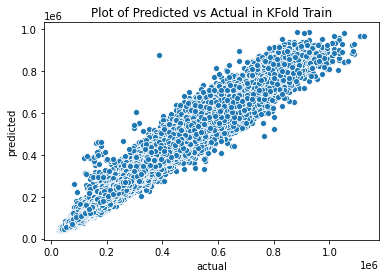

In [84]:
# validation plot
ax = sns.scatterplot(x=y, y=pred_train)
ax.set(xlabel='actual', ylabel='predicted', title='Plot of Predicted vs Actual in KFold Train')
plt.show()

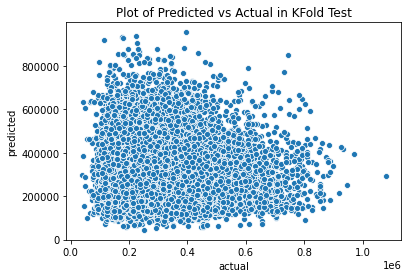

In [85]:
# test plot
ax = sns.scatterplot(x=y_test, y=pred_test['mean'])
ax.set(xlabel='actual', ylabel='predicted', title='Plot of Predicted vs Actual in KFold Test')
plt.show()

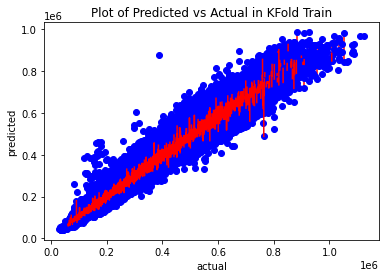

In [86]:
def custom_binscatter(x, y, nbins = 10, xlabel='actual', ylabel='predicted', 
                      title='Plot of Predicted vs Actual in KFold Train'):
    """
    Adapted code from https://stackoverflow.com/questions/15556930/turn-scatter-data-into-binned-data-with-errors-bars-equal-to-standard-deviation
    """
    n, _ = np.histogram(x, bins=nbins)
    sy, _ = np.histogram(x, bins=nbins, weights=y)
    sy2, _ = np.histogram(x, bins=nbins, weights=y*y)
    mean = sy / n
    std = np.sqrt(sy2/n - mean*mean)

    plt.plot(x, y, 'bo')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='r-')
    plt.show()
    
custom_binscatter(x=y, y=pred_train, nbins= 10000)

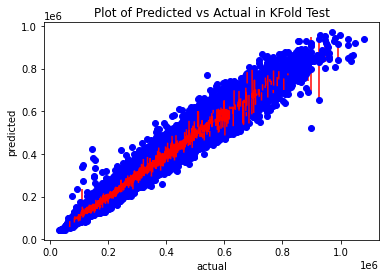

In [87]:
custom_binscatter(x=y_test, y=pred_test['mean'], nbins= 10000, title='Plot of Predicted vs Actual in KFold Test')

In [46]:
lgb.evals_result_.keys()

dict_keys(['training', 'valid_1'])

In [ ]:
# to do
# save rmse scores over iters 
# plot rmse over iters
# plot feature importance
# do this for each fold

In [30]:
dir(lgb)

['_Booster',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_base_doc',
 '_best_iteration',
 '_best_score',
 '_check_n_features',
 '_class_map',
 '_class_weight',
 '_classes',
 '_estimator_type',
 '_evals_result',
 '_fobj',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_n_classes',
 '_n_features',
 '_objective',
 '_other_params',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 'best_iteration_',
 'best_score_',
 'booster_',
 'boosting_type',
 'class_weight',
 'colsample_bytree',
 'evals_result_',
 'feature_importances_',
 'fit',
 'get_params',
 'importance_type',
 'learning_rate',
 'max_depth',
 '

In [82]:
# manual error analysis
tmp_df = pd.concat([X_test, y_test], axis=1)
tmp_df = pd.concat([tmp_df, pd.DataFrame(pred_test)], axis=1)
tmp_df[(y_test<200000) & (pred_test['mean']>800000)]

,month,town,flat_type,flat_model,region,lease_commence_date,floor_area_sqm,commercial_CBD,commercial_type_CR,commercial_type_IEBP,...,station_NE_,station_NE_,station_CC_,station_DT_,hawker__,malls__,resale_price,0,1,mean
2432,2005-10,ang mo kio,4 room,new generation,north-east region,1980,91.0,10.3973,4.6218,3.0571,...,4.9821,4.9821,3.2904,7.3332,0.3084,1.1303,195300.0,849929.123486,871552.059716,860740.591601
2921,2001-03,bukit panjang,4 room,model a,west region,1988,104.0,14.4822,5.9221,3.8738,...,12.1017,12.1017,8.8913,11.0756,0.8991,0.3048,183600.0,857911.020219,806665.671837,832288.346028
6037,2002-09,bukit merah,3 room,improved,central region,1975,70.0,3.6908,3.6908,3.7211,...,2.1468,2.1468,2.4542,2.5344,0.2807,0.6794,163800.0,871657.804621,859747.851949,865702.828285
25096,2001-03,jurong east,3 room,improved,west region,1979,72.0,12.4335,2.2075,0.9898,...,10.1553,10.1553,4.9669,10.0790,0.6182,1.4874,96750.0,835624.625824,810714.452432,823169.539128
25288,2007-03,jurong west,4 room,model a,west region,1996,105.0,19.0157,4.6742,0.4496,...,16.8359,16.8359,11.5787,13.7009,0.9240,0.2464,175500.0,923384.507236,916321.849975,919853.178606
27953,2006-09,bedok,4 room,new generation,east region,1977,91.0,10.5039,2.3685,3.1842,...,6.4319,6.4319,5.1924,2.4270,0.3150,1.1103,195300.0,798208.523728,850222.485769,824215.504748
33472,2003-04,woodlands,4 room,model a2,north region,1998,96.0,17.6174,1.0756,2.7808,...,12.0405,12.0405,10.9280,14.2409,0.8877,0.3988,179100.0,908674.920845,938911.890174,923793.405510
58642,2007-12,bedok,3 room,new generation,east region,1978,67.0,10.2154,3.6294,3.2237,...,7.4852,7.4852,5.2582,2.9120,0.4663,1.1171,180000.0,863930.171931,854227.805767,859078.988849
60538,2001-03,toa payoh,3 room,improved,central region,1970,66.0,5.6881,5.6881,6.2154,...,1.5607,1.5607,1.7134,3.4648,0.2924,1.1120,135000.0,832768.006156,806917.750612,819842.878384
60898,2000-02,yishun,3 room,simplified,north region,1986,64.0,16.5895,4.7370,4.3302,...,8.7476,8.7476,9.4505,13.4685,0.2553,0.9987,115920.0,900841.304312,929110.652258,914975.978285
